# Working with GEMS Hydro APIs
This notebook demonstrates some key features of the GEMS water APIs, including:
1. Lakes
2. Lake Quality
3. Watersheds

API Documentation can be found [here](https://exchange-1.gems.msi.umn.edu/hydro/v2/docs)

**Note**: Maps created with ipyleaflet may not render in the PDF version of this notebook.

In [1]:
# Imports
import requests
from zipfile import ZipFile
from io import BytesIO
import json
import pandas as pd
import fiona
from shapely.geometry import shape, Polygon, mapping
import geopandas as gp
from ipyleaflet import Map, GeoData, basemaps, LayersControl, GeoJSON as ll_GeoJSON
from ipywidgets import HTML
import rasterio
import numpy as np
import pyproj
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

## Setup
### Sample Data
We need some sample geospatial data to illustrate the some of the APIs geospatial functionality. For those examples, we use level 4 Minnesota Ecological Zone boundaries. Below we download the zip file and open the included shapefile in memory, then convert it to GeoJSON. The generated GeoJSON contains "features" for each ecological region in the shapefile. A feature looks like this:
```
{
    'type': 'Feature',
    'properties': {
        'EPA_REGION': 5,
        'L1_KEY': '9  GREAT PLAINS',
        'L2_KEY': '9.2  TEMPERATE PRAIRIES',
        'L3_KEY': '47  Western Corn Belt Plains',
        'L4_KEY': '47b  Des Moines Lobe',
        'NA_L1CODE': '9',
        'NA_L1NAME': 'GREAT PLAINS',
        'NA_L2CODE': '9.2',
        'NA_L2NAME': 'TEMPERATE PRAIRIES',
        'NA_L3CODE': '9.2.3',
        'NA_L3NAME': 'Western Corn Belt Plains',
        'OBJECTID': 5189,
        'STATE_NAME': 'Minnesota',
        'Shape_Area': 30836613798.1,
        'Shape_Leng': 877778.21585,
        'US_L3CODE': '47',
        'US_L3NAME': 'Western Corn Belt Plains',
        'US_L4CODE': '47b',
        'US_L4NAME': 'Des Moines Lobe'
    },
    'geometry': {
        'type': 'Polygon', 'coordinates': ['...list of coords...']
     }
}
```
For our purposes we primarily use the Level 1 Name field (`NA_L1NAME`) but the notebook can be modified to look at other levels.

In [2]:
res = requests.get('https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/mn/mn_eco_l4.zip', verify=False)
zipfile = BytesIO(res.content)
crs = pyproj.CRS('ESRI:102039')
with fiona.BytesCollection(zipfile.read()) as src:
    tmp_gdf = gp.GeoDataFrame.from_features(src, crs=crs)
    
tmp_gdf = tmp_gdf.to_crs(4326)
eco_zones = json.loads(tmp_gdf.to_json())['features']

### Create a Session
We use a request session and an API key to interact with the APIs. Note that this cell may need to be re-run if there is a long gap between sent requests.
Note that we have a `api_key.py` file in the same directory as this notebook. The file contains only the below line.
```
key = 'SECRET'
```

In [3]:
from requests import Session
import sys
sys.path.append('..')
from api_key import key

s = Session()
s.headers.update({'apikey': key})

api_url = 'https://exchange-1.gems.msi.umn.edu/hydro/v2'

## Lake Search
#### /lake-mn/search
The API allows the user to find lakes via the lake's name or with a geometry filter. We currently have coverage for the state of MN and plan to expand that footprint.

The search query returns a list of JSON objects where each list item corresponds to a lake that matches the search term. Example item:

```
{
    'id': '27013300',
    'name': 'Minnetonka',
    'acres': 14729.6182383
}
```
The a lake search object simply contains the lake's ID, name and area in acres. Users can obtain additional information using one or more lake IDs after selecting targets from the search result.

### Search - Area of Interest
#### [POST] /lake-mn/search
Using a POST request with the /lake-mn/search endpoint we can search for lakes of interest that fall within some target geometry.

Below we find 50 lakes that fall within some ecological region from our sample data. We store the lakes in the `lakes_in_zone` list.

In [4]:
# a bounding box is required for several endpoints, below we use a rough bounding box for MN
project_bbox = '-97.5,43,-89.0,49.5'

zone = eco_zones[1]

with s.post(f'{api_url}/lake-mn/search', json=zone['geometry'], params={'limit': 50}) as req:
    lakes_in_zone = req.json()

pd.json_normalize(lakes_in_zone).head()

,id,name,acres
0,12007500,Unnamed,20.576111
1,37007500,Unnamed,71.488046
2,12007900,Unnamed,40.415455
3,37004600,Lac Qui Parle,7139.399750
4,37034100,Moen Marsh,31.296367


### Search - Lake Name
#### [GET] /lake-mn/search
Using a GET request with the /lake-mn/search endpoint we can search for lakes of interest by the name of the lake. 

Below we loop through a list of target lake names, sending a request for each and collecting the results in the `target_lakes` list. The request parameters to search for "vermilion" look like this:
```
{
    "lake_name": "vermilion"
}
```

In [5]:
target_lakes = []
for name in ['mille lacs', 'vermilion', 'bemidji', 'minnetonka']:
    lake_search = {
        "lake_name": name,
        "limit": 1,
        'bbox': project_bbox
    }
    with s.get(f'{api_url}/lake-mn/search', params=lake_search) as req:
        target_lakes += req.json()

# Display the search results in a dataframe.
pd.json_normalize(target_lakes)

,id,name,acres
0,48000200,Mille Lacs,128649.026995
1,69037800,East Vermilion,39818.914362
2,04013002,Bemidji,6600.840003
3,27013300,Minnetonka,14729.618238


## Lake Geometry
#### [GET] /lake-mn/{lake_id}/geometry
Using a GET request with the /lake-mn/{lake_id}/geometry endpoint we can obtain the GeoJSON geometry for a lake given it's ID. Below we loop through the `lakes_in_zone` list that we created above and use each lake's ID to obtain the it's geometry.

We load the GeoJSON into a `shapely.geometry` object using `shape` and update the `lakes_in_zone` list to include the geometry. Then, we create a `geopandas.GeoDataFrame` object (`lakes_in_zone_gdf`) from the resulting list.

In [6]:
for lake in tqdm(lakes_in_zone):
    with s.get(f'{api_url}/lake-mn/{lake["id"]}/geometry') as req:
        lake_geom = req.json()['geometry']
    
    # add the lake's geometry to the lakes_in_zone list
    lake.update({'geometry': shape(lake_geom)})

# create and display GeoDataFrame
lakes_in_zone_gdf = gp.GeoDataFrame(lakes_in_zone).set_geometry('geometry')
lakes_in_zone_gdf.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,id,name,acres,geometry
0,12007500,Unnamed,20.576111,"MULTIPOLYGON (((-95.88077 45.05056, -95.88091 ..."
1,37007500,Unnamed,71.488046,"MULTIPOLYGON (((-96.07034 45.04872, -96.07013 ..."
2,12007900,Unnamed,40.415455,"MULTIPOLYGON (((-95.96159 45.10791, -95.96161 ..."
3,37004600,Lac Qui Parle,7139.399750,"MULTIPOLYGON (((-95.88278 45.02788, -95.88293 ..."
4,37034100,Moen Marsh,31.296367,"MULTIPOLYGON (((-96.04685 45.09378, -96.04643 ..."


### Visualizing Results
Now we create a simple map displaying the lakes in our ecological zone of interest and the ecological zone's boundary.

Note: here we use `ipyleaflet`, depending on use case other libraries (namely `matplotlib`) may be more appropriate.

In [7]:
# Set the center of the map to match the centroid of our ecological zone
map_center = shape(zone['geometry']).centroid.xy
map_center = [map_center[1][0], map_center[0][0]]

# Choose one of the basemaps below and uncomment that line
# OpenStreetMap basemap
zone_lakes_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=map_center, zoom=7)
# ESRI Satellite Imagery Basemap
# zone_lakes_map = Map(basemap=basemaps.Esri.WorldImagery, center=map_center, zoom=7)

# Create the lake polygons layer
geo_data = GeoData(geo_dataframe = lakes_in_zone_gdf,
                   style={'color': 'yellow', 'fillOpacity':0.01},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 0.2},
                   name = 'Lakes in Ecological Zone')

In [8]:
# Create the ecological zone boundary layer
zone_layer = ll_GeoJSON(
    data=zone['geometry'],
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    }
)

In [9]:
# Add the layers to the map
zone_lakes_map.add_layer(zone_layer)
zone_lakes_map.add_layer(geo_data)
# Display the map
zone_lakes_map.add_control(LayersControl())
display(zone_lakes_map)

Map(center=[44.34264496927081, -94.98217976664125], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Lake Quality
The lake quality dataset currently includes raster data and derived statistics for Secchi Depth and Chlorophyll. Rasters are generated for each month for the state of Minnesota with plans to expand the footprint.

Note that within the scope of the API:
- A **layer** is simply a variable (e.g., Secchi Depth), and
- An **object** is an observation of one variable for a given point in time

### Get the Dataset `keyname`
This is used to query the Lake Quality dataset

In [10]:
with s.get(f'{api_url}/datasets') as req:
    layers = req.json()

dataset_df = pd.json_normalize(layers)
display(dataset_df)
keyname = dataset_df.loc[dataset_df['name'] == 'Lake Quality', 'keyname'].values[0]

,name,description,id,keyname,app_name
0,Lake Quality,Lake water quality data,21,lake-quality,hydro


### Exploring Available Layers
#### [GET] /{keyname}/layer
To use the lake quality objects we first need a layer ID. Our variable of interest in this example is Secchi Depth. Below we use a GET request with the /layer endpoint to get a list of all available layers and store the ID for Secchi Depth.

This query returns a list of JSON with each list item corresponding to an available layer. Example:
```
{
    'name': 'Secchi_Depth',
    'units': 'meters',
    'description': 'Average estimated Secchi Depth based on S2 data (version m0c)',
    'id': 2
}
```

In [11]:
with s.get(f'{api_url}/{keyname}/layer') as req:
    layers = req.json()

pd.json_normalize(layers)

,name,units,description,discrete,id
0,Sample,m,A sample layer,False,302
1,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,False,303
2,Chlorophyll,micrograms per Liter,Average estimated Chlorophyll mass density bas...,False,304


In [12]:
# store the layer_id for Secchi Depth
layer_id = layers[1]['id']

### Searching for Objects
#### [GET] /{keyname}/object/search
To access an object we need to identify the object's ID. Below we use a GET request with the /object/search endpoint and filter on our `layer_id` to get a list of possible objects of interest.

This query returns a list of JSON objects with each list item corresponding to an object that matches the user's search. Example:
```
{
    'id': 187371,
    'grid_id': 3,
    't_ranges': [{'begin': '2021-05', 'end': '2021-06'}],
    't_key': None,
    't_description': None,
    'name': 'Secchi_Depth',
    'units': 'meters',
    'description': 'Average estimated Secchi Depth based on S2 data (version m0c)',
    'layer_id': 303
}
```

In [13]:
filters = {
    'layer': layer_id,
    'limit': 10,
    'begin': '2019-01-01',
    'end': '2020-01-01',
    'bbox': project_bbox
}
with s.get(f'{api_url}/{keyname}/object/search', params=filters) as req:
    objs = req.json()

pd.json_normalize(objs)

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187405,3,"[{'begin': '2019-05', 'end': '2019-06'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
1,187406,3,"[{'begin': '2019-06', 'end': '2019-07'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
2,187407,3,"[{'begin': '2019-07', 'end': '2019-08'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
3,187408,3,"[{'begin': '2019-08', 'end': '2019-09'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
4,187409,3,"[{'begin': '2019-09', 'end': '2019-10'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
5,187410,3,"[{'begin': '2019-10', 'end': '2019-11'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
6,187411,4,"[{'begin': '2019-05', 'end': '2019-06'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
7,187412,4,"[{'begin': '2019-06', 'end': '2019-07'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
8,187413,4,"[{'begin': '2019-07', 'end': '2019-08'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
9,187414,4,"[{'begin': '2019-08', 'end': '2019-09'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303


#### Refining an Object Search
There are more filtering options than above (see API documentation for more information).

Below we add `begin` and `end` filters for our target month and year (May 2020). We then decide to proceed with GEMS grid level 4 data (100m resolution) and store the ID for that object.

In [14]:
filters = {
    'layer': 303,
    'begin': '2020-05-01',
    'end': '2020-06-01',
    'bbox': project_bbox
}
with s.get(f'{api_url}/{keyname}/object/search', params=filters) as req:
    objs = req.json()
    
pd.json_normalize(objs)

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187423,4,"[{'begin': '2020-05', 'end': '2020-06'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303
1,187417,3,"[{'begin': '2020-05', 'end': '2020-06'}]",None,None,Secchi_Depth,meters,Average estimated Secchi Depth based on S2 dat...,303


In [15]:
# Store the ID for our selected object
object_id = objs[1]['id']

### Accessing Object Data
There are a few options for accessing lake quality data given an `object_id`. Users can access the following:
- Full object
- Filtered by a provided bounding box
- Filtered by some geometry (GeoJSON)
- For a lake using the lake ID

#### Accessing a Full Object
##### [GET] /{keyname}/object/{object_id}/raster
Users can access a full object raster file given the `object_id`. Below we use a GET request to obtain the full Secchi Depth raster for May 2020.

We use `rasterio.MemoryFile` to keep the returned file in memory without writing to disk. We then calculate a few statistics based on the pixel values.

In [16]:
# Requesting the full file.
with s.get(f'{api_url}/{keyname}/object/{object_id}/raster', params={'bbox': project_bbox}) as req:
    rast = req.content

# Opening the file and calculating stats
with rasterio.MemoryFile(rast) as memfile:
    with memfile.open() as dataset:
        data = dataset.read()
        data = data[data != dataset.meta['nodata']]
        stats = {
            'pixel count': data.size,
            'sum': np.sum(data),
            'mean': np.mean(data),
            'std': np.std(data),
            'min': np.min(data),
            'max': np.max(data)
        }
        
pd.json_normalize(stats)

,pixel count,sum,mean,std,min,max
0,108961,313280.625,2.875163,1.517242,0.005473,15.0


#### Accessing a Filtered Object - Bounding Box
##### [GET] /{keyname}/object/{object_id}/raster
Below we add a bounding box filter to the previous query. The only difference is that now we pass a `bbox` parameter. The `bbox` parameter is a string with the following formatting: `'min_lon,min_lat,max_lon,max_lat'`. Example:
```
{
    'bbox': '-95.555,46.777,-93.790,48.375'
}
```

In [17]:
filters = {
    'bbox': '-95.555,46.777,-93.790,48.375'
}

with s.get(f'{api_url}/{keyname}/object/{object_id}/raster', params=filters) as req:
    rast = req.content

with rasterio.MemoryFile(rast) as memfile:
    with memfile.open() as dataset:
        data = dataset.read()
        data = data[data != dataset.meta['nodata']]
        stats = {
            'pixel count': data.size,
            'sum': np.sum(data),
            'mean': np.mean(data),
            'std': np.std(data),
            'min': np.min(data),
            'max': np.max(data)
        }
        
pd.json_normalize(stats)

,pixel count,sum,mean,std,min,max
0,7986,19981.189453,2.502027,0.97592,0.304595,11.830864


##### Stats - Server Side
###### [GET] /object/{object_id}/stats
To avoid downloading the file users can request stats directly from the server. Below we repeat the above bounding box query using the `/object/{object_id}/stats` endpoint to request only the summary data for the filtered object.

Note that differences between client and server side stat calculation are related to precision.

This query returns a JSON object containing the pixel count, sum, mean, standard deviation, minimum and maximum values for the object data. Example:
```
{
    'count': 308683,
    'sum': 748666.8937019855,
    'mean': 2.4253583569616257,
    'stddev': 0.9275613626757652,
    'min': 0.17315661907196045,
    'max': 14.288928031921387
}
```

In [18]:
with s.get(f'{api_url}/{keyname}/object/{object_id}/stats', params=filters) as req:
    stats = req.json()
    
pd.json_normalize(stats)

,count,sum,mean,stddev,min,max
0,7986,19981.189988,2.502027,0.975919,0.304595,11.830864


#### Accessing a Filtered Object - GeoJSON
##### [POST] /{keyname}/object/{object_id}/stats
Now we use GeoJSON geometry to filter the object. Below we use a POST with the /object/{object_id}/stats endpoint and geometries to obtain May 2020 Secchi Depth stats for all of our ecological zones.

Note that this approach can also be applied to obtain the filtered raster data with a POST to /object/{object_id}/raster

In [19]:
zone_stats = []
for eco_zone in tqdm(eco_zones):
    properties = eco_zone['properties']
    with s.post(f'{api_url}/{keyname}/object/{object_id}/stats', json=eco_zone['geometry']) as req:
        res = req.json()
        if req.status_code == 404:
            continue
        res.update({'zone_id': eco_zone['id']})
        res.update({'geometry': shape(eco_zone['geometry'])})
        res.update({'zone_name': eco_zone['properties']['NA_L1NAME']})
        zone_stats.append(res)

eco_zone_stats_gdf = gp.GeoDataFrame(zone_stats).set_geometry('geometry')
eco_zone_stats_gdf.head()

  0%|          | 0/36 [00:00<?, ?it/s]

,count,sum,mean,stddev,min,max,zone_id,geometry,zone_name
0,1,0.371575,0.371575,0.000000,0.371575,0.371575,0,"POLYGON ((-92.08988 46.77631, -92.08924 46.775...",NORTHERN FORESTS
1,2960,4486.313949,1.515647,1.166072,0.175537,12.580441,1,"POLYGON ((-94.94337 45.13868, -94.94204 45.137...",GREAT PLAINS
2,270,465.579600,1.724369,1.750551,0.321159,14.627620,2,"POLYGON ((-92.97682 44.28709, -92.97695 44.286...",GREAT PLAINS
3,157,269.692756,1.717788,1.255369,0.421783,9.373655,3,"POLYGON ((-92.78530 44.73638, -92.78277 44.735...",GREAT PLAINS
4,1065,2219.324663,2.083873,0.993939,0.235187,14.532327,4,"POLYGON ((-95.82125 48.50474, -95.82492 48.499...",GREAT PLAINS


In [20]:
eco_zone_stats_gdf.groupby('zone_name')[['mean']].mean()

,mean
zone_name,
EASTERN TEMPERATE FORESTS,2.420780
GREAT PLAINS,2.013992
NORTHERN FORESTS,2.433357


#### Accessing Data for a Specific Lake
##### [GET] /lake-mn/{lake_id}/object/{object_id}/stats
We can access object data and stats for a specific lake using a GET request with the /lake endpoint. Below we grab the Secchi Depth stats for each of the 50 lakes we found above (`lakes_in_zone`) in the ecological region.

Note that some lakes actually do not contain Secchi Depth observations for May 2020 and some contain only 1 pixel worth of data.

In [21]:
lakes_in_zone_stats = []
for lake in tqdm(lakes_in_zone):
    with s.get(f'{api_url}/lake-mn/{lake["id"]}/object/{object_id}/stats') as req:
        lakes_in_zone_stats.append(req.json())
        
pd.json_normalize(lakes_in_zone_stats).sort_values(by='count', ascending=False).head()

  0%|          | 0/50 [00:00<?, ?it/s]

,count,sum,mean,stddev,min,max
3,30,19.193593,0.639786,0.124656,0.414555,0.802567
29,1,1.735236,1.735236,0.000000,1.735236,1.735236
46,1,2.708677,2.708677,0.000000,2.708677,2.708677
21,1,1.364942,1.364942,0.000000,1.364942,1.364942
20,1,1.680083,1.680083,0.000000,1.680083,1.680083


##### [GET] /lake-mn/{lake_id}/object/{lake_quality_object_id}/raster
We can also access the filtered raster for a specific lake with a GET request and the /lake-mn endpoint. Below we calculate the same stats as above with the raster data.

Note that this time we drop lakes where there are no observations.

In [22]:
lakes_in_zone_stats = []
for lake in tqdm(lakes_in_zone):
    with s.get(f'{api_url}/lake-mn/{lake["id"]}/object/{object_id}/raster') as req:
        rast = req.content
    with rasterio.MemoryFile(rast) as memfile:
        with memfile.open() as dataset:
            data = dataset.read()
            data = data[data != dataset.meta['nodata']]
            if data.size > 0:
                stats = {
                    'pixel count': data.size,
                    'sum': np.sum(data),
                    'mean': np.mean(data),
                    'std': np.std(data),
                    'min': np.min(data),
                    'max': np.max(data)
                }
            else:
                continue
            lakes_in_zone_stats.append(stats)
            
pd.json_normalize(lakes_in_zone_stats).head()

  0%|          | 0/50 [00:00<?, ?it/s]

,pixel count,sum,mean,std,min,max
0,30,19.193594,0.639786,0.124656,0.414555,0.802567
1,1,1.680083,1.680083,0.000000,1.680083,1.680083
2,1,1.364942,1.364942,0.000000,1.364942,1.364942
3,1,1.735236,1.735236,0.000000,1.735236,1.735236
4,1,1.499084,1.499084,0.000000,1.499084,1.499084


### Visualizing Object Data
Below we create visualizations to explore relationships between the ecological zones and the lake quality data with `matplotlib`. The approach for obtaining data is the same as above.

##### Imports

In [23]:
import matplotlib
matplotlib.use('nbagg')
from matplotlib import pyplot
from rasterio.plot import show
from shapely.geometry import Polygon
from shapely.ops import transform
from matplotlib.lines import Line2D
%matplotlib widget

##### Setup Transforms
We need to transform the region polygons to the GEMS grid CRS (EPSG=6933) to plot them with the raster data.

In [24]:
wgs84 = pyproj.CRS('EPSG:4326')
gems_grid_crs = pyproj.CRS('EPSG:6933')
project = pyproj.Transformer.from_crs(wgs84, gems_grid_crs, always_xy=True).transform

#### Visualizing Summary Stats
Below we create a simple map illustrating ecological region averages for Secchi Depth. Region boundaries correspond to the region's zone classification.

##### Initialize Matplotlib Figures and Define Border Colors

In [25]:
%%capture
# using %%capture to prevent dummy plots from displaying in jupyter lab
fig_mean, ax_mean = pyplot.subplots(figsize=(7,7))
zone_colors = {
    'NORTHERN FORESTS': 'green',
    'EASTERN TEMPERATE FORESTS': 'blue',
    'GREAT PLAINS': 'yellow',
}

##### Add the Data to the Figure
We use `geopandas` built in plot function to add the data to the figure. Here we define the colormap, border colors, labels, etc.

In [26]:
eco_zone_stats_gdf.crs = wgs84
eco_zone_stats_gdf = eco_zone_stats_gdf.to_crs(gems_grid_crs)

_ = eco_zone_stats_gdf.plot(
    ax=ax_mean,
    edgecolor=[zone_colors[zone_name] for zone_name in eco_zone_stats_gdf.zone_name],
    lw=1.5,
    column='mean',
    cmap='OrRd',
    legend=True,
    legend_kwds={'label': "Mean(Average Estimated Secchi Depth)",'orientation': "horizontal"}
)

##### Add Legends and Show the Figure

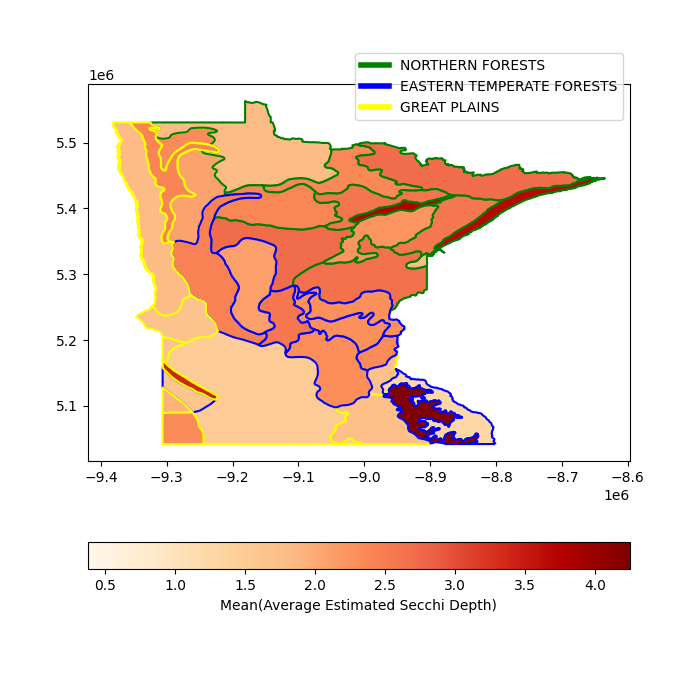

In [27]:
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in [x[1] for x in zone_colors.items()]]
ax_mean.legend(custom_lines,
               [x[0] for x in zone_colors.items()],
               bbox_to_anchor=(1, 1.1))
fig_mean.show()

#### Visualizing Raster Data
Similar to client side stats calculation, `rasterio.MemoryFile` allows us to obtain, visualize and discard raster data from the API on-the-fly. This lets us quickly explore the data without requiring disk space or the loading of all ecological region rasters into memory.

##### Initialize Matplotlib Figures
We use a dummy figure (`fig_dummy`) to generate a "global" colorbar. Without this, `matplotlib` will use a colorbar for only the last region in the loop.

For the colorbar, we also obtain the "global" min and max values from `distract_stats_df`.

In [28]:
%%capture
# using %%capture to prevent dummy plots from displaying in jupyter lab
fig_overlay, ax_overlay = pyplot.subplots(figsize=(7,7))
fig_dummy, ax_dummy = pyplot.subplots(figsize=(7,7))
# Get the minimum and maximum values for all regions for colorbar
total_min = eco_zone_stats_gdf['min'].min()
total_max = eco_zone_stats_gdf['max'].max()

##### Request Data and Add to the Figure
We loop through the regions of interest and:
1. Obtain the region's raster data with a POST to /object/{object_id}/raster.
2. Transform the region Polygon CRS to the GEMS grid CRS.
3. Load the raster data into memory with rasterio.
4. Plot the raster data on the figure with the pre-defined value min/max values from above.
5. Plot the region's polygon on the figure with the border color corresponding to the region's ecological zone classification.

In [29]:
for zone in tqdm(eco_zones):
    properties = zone['properties']
        
    with s.post(f'{api_url}/{keyname}/object/{object_id}/raster', json=zone['geometry']) as req:
        if req.status_code == 404 or req.status_code == 400:
            continue
        rast = req.content

    poly = Polygon([tuple(pt) for pt in zone['geometry']['coordinates'][0]])
    poly = transform(project, poly)

    with rasterio.MemoryFile(rast) as memfile:
        with memfile.open() as dataset:
            data = dataset.read()
            image_hidden = ax_dummy.imshow(data[0], cmap='OrRd', vmin=total_min, vmax=total_max)
            # Plot pixel data for Ecological Zone
            show(dataset, ax=ax_overlay, cmap='OrRd', vmin=total_min, vmax=total_max)
            color = zone_colors[properties['NA_L1NAME']]
            # Add ecological zone borders for both overlay and mean figures
            ax_overlay.plot(*poly.exterior.xy, color=color)

  0%|          | 0/36 [00:00<?, ?it/s]

##### Add Legends and Show the Figure
At this scale the data can be hard to see. Use the zoom tools to examine smaller areas.

Note: this figure can slow down notebook performance. If there are issues, click the button in the top right corner.

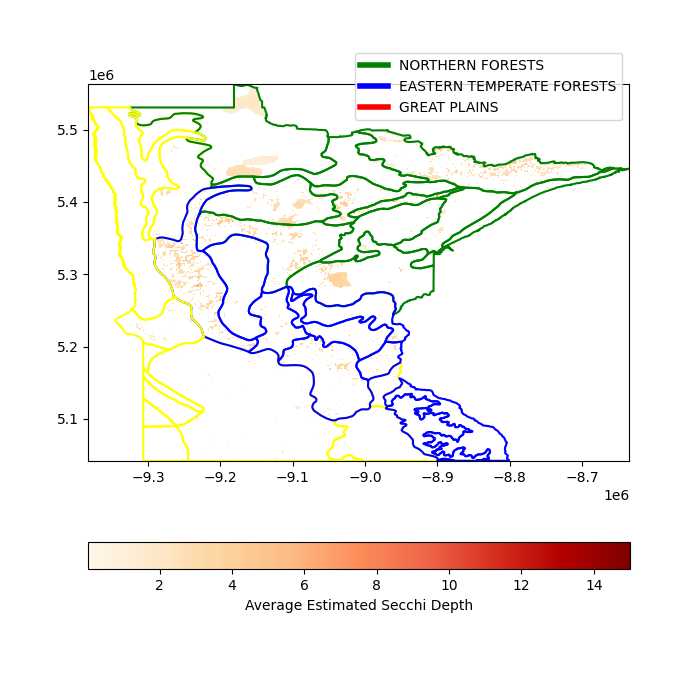

In [30]:
# Add a custom colorbar to the image
fig_overlay.colorbar(image_hidden, ax=ax_overlay, location='bottom', label="Average Estimated Secchi Depth")
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
ax_overlay.legend(custom_lines,
               ['NORTHERN FORESTS', 'EASTERN TEMPERATE FORESTS', 'GREAT PLAINS'],
               bbox_to_anchor=(1, 1.1))
fig_overlay.show()

## Watersheds/Catchments
The catchment API serves watershed catchment data for the state of Minnesota with plans to expand the footprint. The API allows users to:
- Identify the body of water that a geographical point will drain to given a target HUC level.
- Determine the MN DNR level 9 catchment(s) that drain to a lake given a lake ID.
- Identify the MN DNR level 9 catchment that a point lies in as well as the upstream and downstream catchments.

Examples are provided below.

### Accessing Basic HUC Watersheds
##### [GET] and [POST] /catchment/search
We can find the DNR catchment for locations across Minnesota at any of the DNR levels. The information contained in the catchment objects is dependent on the DNR level of interest.

Below we obtain the DNR level 7 catchment for an arbitrary point with a GET request. The level is specified by `mndnr_level`. The default DNR level is level 9.

In [31]:
catch_search_args = {
    'lat': 45.9592,
    'lon': -93.6146,
    'mndnr_level': 7
}
with s.get(api_url+'/catchment/search/point', params=catch_search_args) as req:
    target_catchment = req.json()
    
pd.json_normalize(target_catchment)

,id,minor_name,major,major_name,sq_miles,prod_year,source
0,21019.0,Rum R,21.0,Rum River,17.0,2009.0,DNR Catchment Dataset


Below we use POST requests to /catchment/search and GET requests to /catchment/{id}/geometry to get level 8 catchments contained by the level 7 catchment that we obtained above.

First we obtain the level 7 catchment's geometry.

In [32]:
with s.get(f'{api_url}/catchment/{int(target_catchment["id"])}/geometry', params={'mndnr_level': 7}) as req:
    catch_geom = req.json()
    target_catchment.update({'geometry': catch_geom['geometry']})

Next we obtain geometries for level 8 catchments contained by the level 7 catchment above.

Note that for time we limit the maximum number of catchments to 100. In practice a user could use the `limit` and `offset` parameters to collect all catchments at each level.

In [33]:
lvl_8_catchments = []

with s.post(api_url+'/catchment/search',
            json=target_catchment['geometry'],
            params={'mndnr_level': 8, 'limit': 100}) as req:
    catches = req.json()
    
for catch in catches:
    with s.get(api_url+f'/catchment/{catch["id"]}/geometry', params={'mndnr_level': 8}) as req:
        catch_geom = req.json()
        catch.update({'geometry': shape(catch_geom['geometry'])})
        
lvl_8s_gdf = gp.GeoDataFrame(catches).set_geometry('geometry')

Now we map the catchments.

Note that because borders intersect, the spatial query also returns the neighboring catchments.

In [34]:
# Set the center of the map to match the centroid of target lakes
map_center = lvl_8s_gdf.dissolve().centroid[0].xy
map_center = [map_center[1][0], map_center[0][0]]

# Choose one of the basemaps below and uncomment that line
# OpenStreetMap basemap
# m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=map_center, zoom=10)
# ESRI Satellite Imagery Basemap
catch_search_map = Map(basemap=basemaps.Esri.WorldImagery, center=map_center, zoom=10)

# Create the catchments polygons layer
lvl_7_data = GeoData(geo_dataframe = gp.GeoDataFrame(geometry=[shape(target_catchment['geometry'])]),
                   style={'color': 'blue', 'fillOpacity':0.01, 'weight': 5},
                   name = 'Catchment')

lvl_8s_data = GeoData(geo_dataframe = lvl_8s_gdf,
                   style={'color': 'yellow', 'fillOpacity':0.01, 'weight': 1},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 0.2},
                   name = 'Catchment')

# Add the layers to the map
catch_search_map.add_layer(lvl_7_data)
catch_search_map.add_layer(lvl_8s_data)
# Display the map
catch_search_map.add_control(LayersControl())
catch_search_map

Map(center=[45.96995118271462, -93.66924888655787], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Accessing Level 9 Catchments
The Minnesota DNR defines high resolution catchments (tagged with "level 9") for the state. Example level 9 catchment object:
```
{
    'id': '280420052000200',
    'lake_id': '52000200',
    'catch_type': 'LAKE',
    'catch_pos': 'HEADWATER',
    'down_cat': '280420052006300',
    'upadj_cat': 'NONE',
    'huc12_id': '070200071102',
    'acres': 137.685681641,
    'perim_ft': 11984.205642,
    'upsum_ac': 137.685681641,
    'upsum_sqmi': 0.215134751549,
    'depth': None,
    'maj': 28,
    'l_pw_ratio': 9.79279932128,
    'pw_ac': 14.05989004,
    'nwi_ac': 0.0,
    'dca_ratio': 10,
    'total_rati': 10,
    'lk_ratio': 0,
    'sto_ratio': 0
 }
 ```

#### Identifying Upstream Catchments for a Lake
Suppose we are interested in identifying what nearby land may be impacting the health of our lakes via runoff.

We can obtain the level 9 catchment for a lake and use that to get the upstream catchment chain. We can also identify the upstream lakes directly. Below we do this for our `target_lakes` from the text search above.

In [35]:
target_lakes = []
for name in ['mille lacs', 'vermilion', 'bemidji', 'minnetonka']:
    lake_search = {
        "lake_name": name,
        "limit": 1,
        'bbox': project_bbox
    }
    with s.get(f'{api_url}/lake-mn/search', params=lake_search) as req:
        target_lakes += req.json()

##### [GET] /lake-mn/{lake_id}/catchment
Below we use a GET request with the lake IDs for the lakes from our text search above (`target_lakes`) to identify each lake's catchment. These catchment IDs can be used to track the flow of water upstream.

In [36]:
for lake in target_lakes:
    with s.get(f'{api_url}/lake-mn/{lake["id"]}/catchment', params={'bbox': project_bbox}) as req:
        catchment = req.json()
    if catchment is not None:
        lake.update({'catchment_id': catchment['id']})
        
pd.json_normalize(target_lakes)

,id,name,acres,catchment_id
0,48000200,Mille Lacs,128649.026995,210020048000200
1,69037800,East Vermilion,39818.914362,730500069037800
2,04013002,Bemidji,6600.840003,070710004013000
3,27013300,Minnetonka,14729.618238,200550027013300


##### [GET] /catchment/{catchment_id}/geometry
We can use the catchment IDs collected above to obtain each catchment's geometry.

Note that we also get and store the lake geometry for these lakes using `/lake-mn/{lake_id}/geometry`.

In [37]:
for lake in target_lakes:
    with s.get(f'{api_url}/catchment/{lake["catchment_id"]}/geometry') as req:
        catchment_geom = req.json()
    with s.get(f'{api_url}/lake-mn/{lake["id"]}/geometry') as req:
        lake_geom = req.json()
    lake.update({'geometry': shape(lake_geom['geometry'])})
    if catchment is not None:
        lake.update({'catchment_geometry': shape(catchment_geom['geometry'])})
        
target_lake_catchments = gp.GeoDataFrame(target_lakes).set_geometry('catchment_geometry')
target_lake_catchments

,id,name,acres,catchment_id,geometry,catchment_geometry
0,48000200,Mille Lacs,128649.026995,210020048000200,"MULTIPOLYGON (((-93.61302 46.36778, -93.61292 ...","MULTIPOLYGON (((-93.64460 46.36995, -93.64442 ..."
1,69037800,East Vermilion,39818.914362,730500069037800,"MULTIPOLYGON (((-92.58188 47.96553, -92.58177 ...","MULTIPOLYGON (((-92.58782 47.96665, -92.58699 ..."
2,04013002,Bemidji,6600.840003,070710004013000,"MULTIPOLYGON (((-94.84213 47.54130, -94.84155 ...","MULTIPOLYGON (((-94.89546 47.56413, -94.89323 ..."
3,27013300,Minnetonka,14729.618238,200550027013300,"MULTIPOLYGON (((-93.52710 44.93151, -93.52690 ...","MULTIPOLYGON (((-93.61194 44.97857, -93.61120 ..."


##### [GET] /catchment/{catchment_id}/upstream
##### [GET] /catchment/{catchment_id}/upstream/geometry
We can use the catchment IDs collected above to obtain nearby upstream catchments for each lake catchment's. We collect and store the upstream catchments.

Note that we also obtain the upstream catchment geometry and include it in a new `geopandas.GeoDataFrame`.

In [38]:
upstreams = []
for lake in tqdm(target_lakes):
    with s.get(f'{api_url}/catchment/{lake["catchment_id"]}/upstream/geometry') as req:
        for feature in req.json()['features']:
            upstreams.append(
                {
                    'catch_geom': shape(feature['geometry']),
                    'base_lake': lake['name'],
                    'base_lake_id': lake['id']
                }
            )
        
upstreams_gdf = gp.GeoDataFrame(upstreams).set_geometry('catch_geom')
upstreams_gdf.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,catch_geom,base_lake,base_lake_id
0,"MULTIPOLYGON (((-93.64460 46.36995, -93.64442 ...",Mille Lacs,48000200
1,"MULTIPOLYGON (((-93.48150 46.22172, -93.48088 ...",Mille Lacs,48000200
2,"MULTIPOLYGON (((-93.47981 46.20607, -93.47961 ...",Mille Lacs,48000200
3,"MULTIPOLYGON (((-93.46149 46.20074, -93.46172 ...",Mille Lacs,48000200
4,"MULTIPOLYGON (((-93.44763 46.14830, -93.44597 ...",Mille Lacs,48000200


##### Visualizing the Catchments
Below we use ipyleaflet to create a simple map of the lakes, their catchments and their upstream catchments. Lakes are blue in color. The lake's catchment is yellow. Upstream catchments are white.

In [39]:
# Set the center of the map to match the centroid of target lakes
map_center = target_lake_catchments.dissolve().centroid[0].xy
map_center = [map_center[1][0], map_center[0][0]]

# Choose one of the basemaps below and uncomment that line
# OpenStreetMap basemap
# m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=map_center, zoom=10)
# ESRI Satellite Imagery Basemap
lake_catchments_map = Map(basemap=basemaps.Esri.WorldImagery, center=map_center, zoom=6)

# Create the catchments polygons layer
catchments_data = GeoData(geo_dataframe = target_lake_catchments[['catchment_geometry']],
                   style={'color': 'yellow', 'fillOpacity':0.01},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 0.2},
                   name = 'Catchment')

upstream_data = GeoData(geo_dataframe = upstreams_gdf,
                    style={'color': 'white', 'fillOpacity': 0.1},
                    hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                    name = 'Upstream')

lake_data = GeoData(geo_dataframe = target_lake_catchments[['geometry']].set_geometry('geometry'),
                    style={'color': 'blue', 'fillOpacity': 0.1, 'weight': .7},
                    hover_style={'fillColor': 'blue' , 'fillOpacity': 0.2},
                    name = 'Lake')

# Add the layers to the map
lake_catchments_map.add_layer(upstream_data)
lake_catchments_map.add_layer(catchments_data)
lake_catchments_map.add_layer(lake_data)
# Display the map
lake_catchments_map.add_control(LayersControl())
lake_catchments_map

Map(center=[46.700900351282215, -93.31846468741996], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### Identifying Downstream Flow Chains
Now suppose we would like to know what bodies of water could be impacted by management practices on some field.

We can obtain the level 9 catchment(s) that the field lies in and use them to get the downstream catchment chain. We can also identify the downstream lakes directly. Below we do this for an arbitrary Polygon (`field`).

##### Create Polygon
Below we create the `field` Polygon and get it's GeoJSON representation.

In [40]:
field = Polygon(
    [(-96.08295, 44.87755), (-96.07494, 44.87736), (-96.07508, 44.87021), (-96.08281, 44.87049)]
)
# Get GeoJSON for the field polygon
field_geojson = mapping(field)

##### Identifying Catchments by Geometry
##### [POST] /catchment/search
Below we use a POST request to the /catchment/search endpoint with our field geometry (`field_geojson`) to determine which DNR level 9 catchment(s) the field lies on.

Note that this field intersects multiple catchments.

In [41]:
with s.post(f'{api_url}/catchment/search', json=field_geojson) as req:
    field_catchments = req.json()
    
pd.json_normalize(field_catchments)

,id,lake_id,catch_type,catch_pos,down_cat,upadj_cat,huc12_id,acres,perim_ft,upsum_ac,upsum_sqmi,depth,maj,l_pw_ratio,pw_ac,nwi_ac,dca_ratio,total_rati,lk_ratio,sto_ratio
0,240520000000037,None,STREAM,INTERMEDIATE,240520000000036,240520000000032 240520000000030,070200030702,311.594982,17627.086442,729.713318,1.140182,None,24,0.0,0.0,0.0,0,0,0,0
1,240530000000066,None,STREAM,HEADWATER,240530000000056,NONE,070200030702,228.267249,14225.980574,228.267249,0.356669,None,24,0.0,0.0,0.0,0,0,0,0
2,240520000000032,None,STREAM,HEADWATER,240520000000037,NONE,070200030702,223.939540,13410.922219,223.939540,0.349907,None,24,0.0,0.0,0.0,0,0,0,0


We also obtain the geometry for each catchment and add it to `field_catchments`. Then we create a `geopandas.GeoDataFrame` called `field_catchments_gdf`.

In [42]:
for fc in field_catchments:
    with s.get(f'{api_url}/catchment/{fc["id"]}/geometry') as req:
        fc_geom = req.json()
    fc.update({'geometry': shape(fc_geom['geometry'])})
    
field_catchments_gdf = gp.GeoDataFrame(field_catchments).set_geometry('geometry')
field_catchments_gdf[['id', 'geometry']]

,id,geometry
0,240520000000037,"MULTIPOLYGON (((-96.07185 44.86797, -96.07181 ..."
1,240530000000066,"MULTIPOLYGON (((-96.07861 44.88075, -96.07838 ..."
2,240520000000032,"MULTIPOLYGON (((-96.06736 44.87646, -96.06887 ..."


We can use the catchment geometry to determine what share of the field's area each catchment is responsible for. Note that we convert to the GEMS Grid CRS for the area calculations.

In [43]:
field_catchments_gdf.crs = wgs84
field_catchments_gdf = field_catchments_gdf.to_crs(gems_grid_crs)
field_catchments_gdf['share_of_field'] = field_catchments_gdf.area / sum(field_catchments_gdf.area)
field_catchments_gdf[['id', 'share_of_field']]

,id,share_of_field
0,240520000000037,0.407953
1,240530000000066,0.298855
2,240520000000032,0.293192


Below we visualize the field and it's catchments. The field is in white and the catchments are in yellow.

In [44]:
field_catchments_gdf = field_catchments_gdf.to_crs(wgs84)
# Set the center of the map to match the centroid of target lakes
map_center = field_catchments_gdf.dissolve().centroid[0].xy
map_center = [map_center[1][0], map_center[0][0]]

# Choose one of the basemaps below and uncomment that line
# OpenStreetMap basemap
# m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=map_center, zoom=10)
# ESRI Satellite Imagery Basemap
field_catchments_map = Map(basemap=basemaps.Esri.WorldImagery, center=map_center, zoom=14)

# Create the catchments polygons layer
catchments_data = GeoData(geo_dataframe = field_catchments_gdf,
                   style={'color': 'yellow', 'fillOpacity':0.01},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 0.2},
                   name = 'Catchment')

field_data = GeoData(geo_dataframe = gp.GeoDataFrame(geometry=[field]),
                    style={'color': 'white', 'fillOpacity': 0.1, 'weight': .7},
                    hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                    name = 'Field')

# Add the layers to the map
field_catchments_map.add_layer(catchments_data)
field_catchments_map.add_layer(field_data)
# Display the map
field_catchments_map.add_control(LayersControl())
field_catchments_map

Map(center=[44.87226316920893, -96.07965061979274], controls=(ZoomControl(options=['position', 'zoom_in_text',…

##### Identifying Downstream Catchments
##### [GET] /catchment/{catchment_id}/downstream
##### [GET] /catchment/{catchment_id}/downstream/geometry
Now we use the field catchment IDs to identify the downstream flow of water from the field. Note that we use the /geometry endpoint to get each catchment's geometry as well.

In [45]:
field_downstreams = []
for fc in tqdm(field_catchments):
    with s.get(f'{api_url}/catchment/{fc["id"]}/downstream/geometry') as req:
        for feature in req.json()['features']:
            fc_catch = feature['properties']
            fc_catch['geometry'] = shape(feature['geometry'])
            field_downstreams.append(fc_catch)
        
field_downstreams_gdf = gp.GeoDataFrame(field_downstreams).set_geometry('geometry')
field_downstreams_gdf.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,gid,lake_id,catch_id,catch_type,catch_pos,down_cat,upadj_cat,huc12_id,acres,perim_ft,...,l_pw_ratio,pw_ac,nwi_ac,dca_ratio,total_rati,lk_ratio,sto_ratio,id,depth,geometry
0,59696,None,240520000000037,STREAM,INTERMEDIATE,240520000000036,240520000000032 240520000000030,070200030702,311.594982,17627.086442,...,0.00000,0.000000,0.0,0,0,0,0,240520000000037,1,"MULTIPOLYGON (((-96.07185 44.86797, -96.07181 ..."
1,60855,None,240520000000036,STREAM,INTERMEDIATE,240520000000038,240520000000037 240520000000031,070200030702,112.070575,12901.993117,...,0.00000,0.000000,0.0,0,0,0,0,240520000000036,2,"MULTIPOLYGON (((-96.08466 44.85898, -96.08516 ..."
2,60848,None,240520000000038,STREAM,INTERMEDIATE,240520037009800,240520000000036 240520000000029,070200030702,295.923183,16687.751095,...,0.00000,0.000000,0.0,0,0,0,0,240520000000038,3,"MULTIPOLYGON (((-96.08747 44.86890, -96.08728 ..."
3,60838,37009800,240520037009800,LAKE,INTERMEDIATE,240520000000042,240520000000021 240520000000038,070200030702,154.836311,14116.856064,...,7509.25082,28.956102,0.0,5,7509,0,0,240520037009800,4,"MULTIPOLYGON (((-96.10526 44.87158, -96.10476 ..."
4,60830,None,240520000000042,STREAM,INTERMEDIATE,240530000000055,240520037009800,070200030702,185.995369,14478.840479,...,0.00000,0.000000,0.0,0,0,0,0,240520000000042,5,"MULTIPOLYGON (((-96.10411 44.88168, -96.10488 ..."


We can obtain lake information for each unique downstream lake.

In [46]:
fc_lakes = []
for lk_id in field_downstreams_gdf.lake_id.unique():
    if lk_id is None:
        continue
    with s.get(f'{api_url}/lake-mn/{lk_id}') as req:
        if req.json() is not None:
            fc_lakes.append(req.json())
        
pd.json_normalize(fc_lakes).sort_values(by='acres', ascending=False)

,id,name,acres,detail
6,25000100,Pepin,25330.294602,NaN
12,28000500,Blue,9834.223823,NaN
8,79000100,U.S. Lock & Dam #5 Pool,8825.723921,NaN
1,37004600,Lac Qui Parle,7139.399750,NaN
3,19000599,U.S. Lock & Dam #2 Pool,5966.922993,NaN
13,28000100,U.S. Lock & Dam #9 Pool,5806.085243,NaN
9,85001300,Pap Slough,5707.526266,NaN
5,79000599,U.S. Lock & Dam #4 Pool,4355.450305,NaN
4,25001799,U.S. Lock & Dam #3 Pool,2684.545930,NaN
2,52005600,Unnamed,49.282796,NaN


##### Visualizing the Catchment Chain
Below we expand on the previous map to show the field's downtream catchments.

In [47]:
# Set the center of the map to match the centroid of our target field
map_center = gp.GeoDataFrame(geometry=[field]).dissolve().centroid[0].xy
map_center = [map_center[1][0], map_center[0][0]]

# Choose one of the basemaps below and uncomment that line
# OpenStreetMap basemap
# m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=map_center, zoom=10)
# ESRI Satellite Imagery Basemap
field_catchments_map = Map(basemap=basemaps.Esri.WorldImagery, center=map_center, zoom=10)

# Create the catchments polygons layer
catchments_data = GeoData(geo_dataframe = field_downstreams_gdf,
                   style={'color': 'yellow', 'fillOpacity':0.2},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 0.2},
                   name = 'Catchment')

field_data = GeoData(geo_dataframe = gp.GeoDataFrame(geometry=[field]),
                    style={'color': 'white', 'fillOpacity': .8, 'weight': .7},
                    hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                    name = 'Field')

# Add the layers to the map
field_catchments_map.add_layer(catchments_data)
field_catchments_map.add_layer(field_data)
# Display the map
field_catchments_map.add_control(LayersControl())
field_catchments_map

Map(center=[44.87392329411701, -96.07893592071312], controls=(ZoomControl(options=['position', 'zoom_in_text',…